In [13]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from operators import static_hamiltonian, dynamical_hamiltonian, projector
import pypulse

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to mtch 10pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update(tex_fonts)

# Static Hamiltonian

In [3]:
cavity_dim = 20
omega_e = 2*jnp.pi*0.384
g = 2*jnp.pi*0.0001

In [4]:
detuning_list = jnp.linspace(-4*g, 4*g, 1000) 
omega_c_list = detuning_list + omega_e

eigenvalues_list = []
eigenvectors_list = []

for omega_c in omega_c_list:
    H_static = static_hamiltonian(cavity_dim, omega_c, omega_e, g)
    eigenvalues, eigenvectors = jnp.linalg.eigh(H_static)
    eigenvalues_list.append(eigenvalues)
    eigenvectors_list.append(eigenvectors)  

eigenvalues_list = jnp.array(eigenvalues_list)
eigenvectors_list = jnp.array(eigenvectors_list)    

detuning_list = omega_c_list - omega_e   

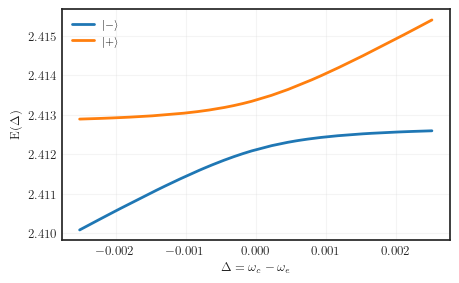

In [5]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(detuning_list, eigenvalues_list[:,1], label=r'$|-\rangle$', linewidth = 2)
plt.plot(detuning_list, eigenvalues_list[:,2], label=r'$|+\rangle$', linewidth = 2)
plt.grid(alpha = 0.2)
plt.xlabel(r'$\Delta = \omega_c - \omega_e$')
plt.ylabel(r'E($\Delta$)')
plt.legend()

In [12]:
# Resonant Case
H_static = static_hamiltonian(cavity_dim, omega_e, omega_e, g)
eigenvalues, eigenvectors = jnp.linalg.eigh(H_static)

P0 = projector(eigenvectors[:,1])
P1 = projector(eigenvectors[:,1])

# Pulse Definition

In [16]:
f_0 = omega_e / (2*jnp.pi)
pulse_fwhm = 2*0.441
pulse_area = jnp.pi
pulse_type = pypulse.pulses.gaussian

f_lim = pypulse.set_frequency_limits(f_0, pulse_fwhm, pulse_type, pulse_fwhm / 10)
f = jnp.linspace(-f_lim, f_lim, 5000) + f_0
frequency_pulse = pypulse.frequency_field(f, f_0, pulse_fwhm, pulse_area, pulse_type)

t_lim = pypulse.set_time_limits(f, frequency_pulse, 0.1 / pulse_fwhm)
t_data = jnp.linspace(-t_lim, t_lim, 5000)
temporal_pulse = pypulse.time_field(f, frequency_pulse, t_data)

In [19]:
def drive(t):
    interpolated_value = jnp.interp(t, t_data, temporal_pulse)
    return jnp.abs(interpolated_value)

In [23]:
t_max = 2*jnp.max(t_data)
t_array = jnp.linspace(-t_max, 4*t_max, 1000)

psi_c_vac = jnp.zeros(cavity_dim).at[0].set(1.0)
psi_q_gnd = jnp.array([0.0, 1.0])

# Total initial state vector |psi_0> = |0, g>
psi_0 = jnp.kron(psi_c_vac, psi_q_gnd)

# Initial density matrix rho(0) = |psi_0><psi_0|
rho_initial = jnp.outer(psi_0, jnp.conj(psi_0))

H_t_func = dynamical_hamiltonian(cavity_dim, omega_e, omega_e, omega_e, g)